In [1]:
import numpy as np
import pandas as pd
import os

import albumentations
import cv2
import timm
import torch.nn as nn
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import pytorch_lightning as pl
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule

import glob
import matplotlib.pyplot as plt

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
SEED = 2023

DATA_DIR = 'data'

TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train')
TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'test')

OUTPUT_DIR = "output"


In [3]:
def create_folds(data: pd.DataFrame, num_splits = 5):
    data["fold"] = -1
    num_bins = int(np.floor(1 + np.log2(len(data)))) # sturge's rule

    data.loc[:, "bins"] = pd.cut(data["Pawpularity"], bins=num_bins, labels=False)
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=SEED)

    for fold_index, (train_idx, val_idx) in enumerate(skf.split(X=data, y=data.bins.values)):
        data.loc[val_idx, 'fold'] = fold_index

    data = data.drop('bins', axis=1)

    return data

In [4]:
dense_features = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]

class PetFinderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, dir: str, augmentations: albumentations.Compose):
        self.ids = df["Id"].values
        if "Pawpularity" in df.keys():
            self.targets = df["Pawpularity"].values
        else:
            self.targets = [-1] * len(df)
        self.dense_features = df[dense_features].values

        image_paths = [os.path.join(dir, f"{x}.jpg") for x in df["Id"].values]
        self.image_paths = image_paths

        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image_id = self.ids[item]

        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        features = self.dense_features[item, :]
        targets = self.targets[item]
        
        return image_id, torch.tensor(features, dtype=torch.float), torch.tensor(image, dtype=torch.float), torch.tensor(targets, dtype=torch.float)
    
class PetFinderDataModule(LightningDataModule):
    def __init__(self, 
                 df_train=None, df_val=None, df_test=None, 
                 train_images_dir=None, val_images_dir=None, test_images_dir=None, 
                 train_augmentations=None, val_augmentations=None, test_augmentations=None, 
                 batch_size=64
                ):
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test

        self.train_images_dir = train_images_dir
        self.val_images_dir = val_images_dir
        self.test_images_dir = test_images_dir

        self.train_augmentations = train_augmentations
        self.val_augmentations = val_augmentations
        self.test_augmentations = test_augmentations

        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_train, self.train_images_dir, self.train_augmentations), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_val, self.val_images_dir, self.val_augmentations), batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_test, self.test_images_dir, self.test_augmentations), batch_size=self.batch_size, shuffle=False) 


In [5]:
class PawpularityModel(pl.LightningModule):
    def __init__(self, model_name="tf_efficientnet_b0_ns", pretrained=True):
        super().__init__()

        self.backbone = timm.create_model(model_name=model_name, pretrained=pretrained, in_chans=3)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 128)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(128 + 12, 1)

        self.criterion = nn.BCEWithLogitsLoss()

        self.validation_step_outputs = []
        self.training_step_outputs = []

    def forward(self, input, features):
        x = self.backbone(input)
        x = self.dropout(x)

        x = torch.cat([x, features], dim=1)
        x = self.out(x)

        return x

    def training_step(self, batch, batch_indexes):
        loss, predictions, labels, rmse = self.step(batch, 'train')
        self.training_step_outputs.append({ "rmse": rmse, "loss": loss })

        return { 'loss': loss, 'predictions': predictions, 'labels': labels }

    def validation_step(self, batch, batch_indexes):
        loss, predictions, labels, rmse = self.step(batch, 'val')
        self.validation_step_outputs.append({ "rmse": rmse, "loss": loss })
        
        return { 'loss': loss, 'predictions': predictions, 'labels': labels }

    def step(self, batch, mode):
        image_ids, features, images, labels = batch
        labels = labels.float() / 100.0

        logits = self.forward(images, features).squeeze(1)
        loss = self.criterion(logits, labels) # using BCELoss to optimize models

        predictions = logits.sigmoid().detach().cpu() * 100
        labels = labels.detach().cpu() * 100
        
        rmse = mean_squared_error(predictions, labels, squared=False) # keeping track of RMSE as it is the competition metric
        rmse = torch.tensor(rmse, dtype=torch.float32)

        self.log(f'{mode}_loss', loss)
        
        return loss, predictions, labels, rmse
    
    def on_train_epoch_end(self):
        rsmes = [x["rmse"] for x in self.training_step_outputs]
        rsme = torch.stack(rsmes).mean()

        self.log(f'train_rmse', rsme, prog_bar=True)

        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        rsmes = [x["rmse"] for x in self.validation_step_outputs]
        rsme = torch.stack(rsmes).mean()

        self.log(f'val_rmse', rsme, prog_bar=True)
        
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 20, eta_min=1e-4)

        return [optimizer], [scheduler]

In [6]:
def create_augmentations(image_size: int):
    train_aug = albumentations.Compose(
        [
            albumentations.SmallestMaxSize(max_size=image_size, p=1),
            albumentations.RandomCrop(image_size, image_size, p=1),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
        ],
        p=1.0,
    )

    valid_aug = albumentations.Compose(
        [
            albumentations.SmallestMaxSize(max_size=image_size, p=1),
            albumentations.CenterCrop(image_size, image_size, p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
        ],
        p=1.0,
    )

    return train_aug, valid_aug

# tf_efficientnet_b0_ns

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
num_splits = 5
df_5 = create_folds(df, num_splits=num_splits)

model_name = "tf_efficientnet_b0_ns"

image_size = 256
train_aug, valid_aug = create_augmentations(image_size)

for fold_index in range(num_splits):
    df_train = df_5[df_5['fold'] != fold_index].reset_index(drop=True)
    df_val = df_5[df_5['fold'] == fold_index].reset_index(drop=True)

    data_module = PetFinderDataModule(
        df_train=df_train, 
        df_val=df_val, 
        train_images_dir=TRAIN_IMAGES_DIR, 
        val_images_dir=TRAIN_IMAGES_DIR, 
        train_augmentations=train_aug,
        val_augmentations=valid_aug,
        batch_size=8
    )

    model = PawpularityModel(model_name=model_name, pretrained=True)

    early_stopping = EarlyStopping(monitor="val_loss")
    lr_monitor = callbacks.LearningRateMonitor()
    loss_checkpoint = callbacks.ModelCheckpoint(dirpath=os.path.join(OUTPUT_DIR, "model_checkpoints", model_name, f"fold_{fold_index}"), filename="best_loss", monitor="val_loss", save_top_k=1, mode="min", save_last=False)

    logger = TensorBoardLogger(os.path.join(OUTPUT_DIR, "logs", model_name))

    trainer = pl.Trainer(max_epochs=20, callbacks=[lr_monitor, loss_checkpoint, early_stopping], logger=logger)
    trainer.fit(model, datamodule=data_module)


c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: output\logs\tf_efficientnet_b0_ns\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | EfficientNet      | 4.2 M 
1 | dropout   | Dropout           | 0     
2 | out       | Linear            | 141   
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | EfficientNet      | 4.2 M 
1 | dropout   | Dropout           | 0     
2 | out       | Linear            | 141   
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | EfficientNet      | 4.2 M 
1 | dropout   | Dropout           | 0     
2 | out       | Linear            | 141   
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | EfficientNet      | 4.2 M 
1 | dropout   | Dropout           | 0     
2 | out       | Linear            | 141   
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | EfficientNet      | 4.2 M 
1 | dropout   | Dropout           | 0     
2 | out       | Linear            | 141   
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[17.621936798095703, 17.587661743164062, 18.851951599121094, 19.50396728515625]


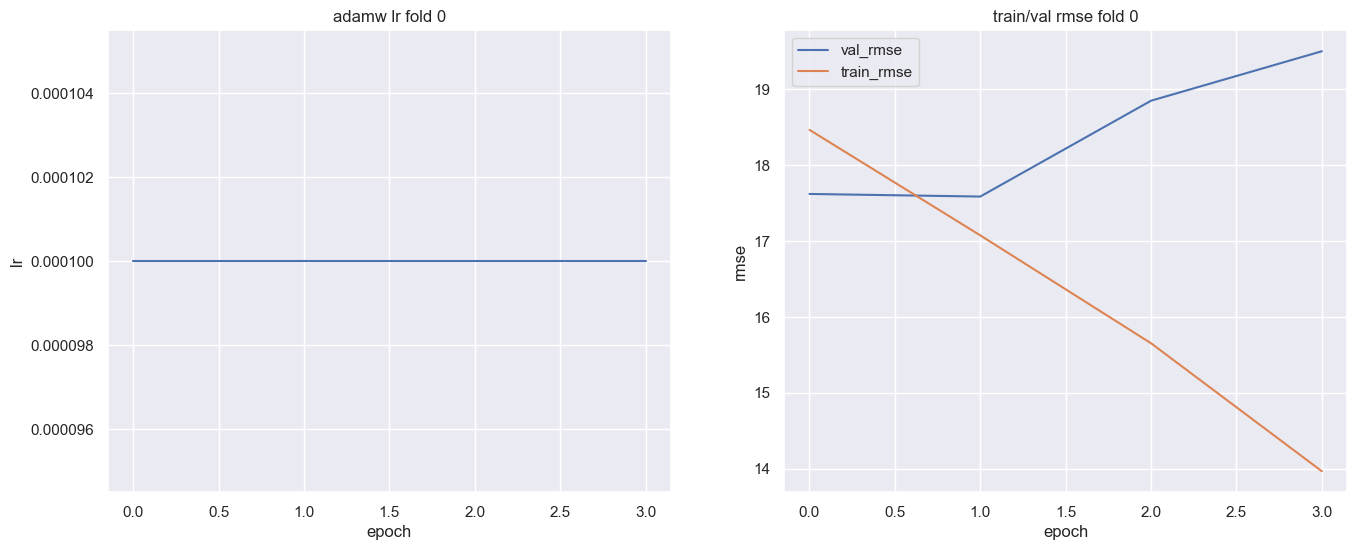

[17.577978134155273, 17.433137893676758, 18.070240020751953, 19.12908172607422, 19.471729278564453]


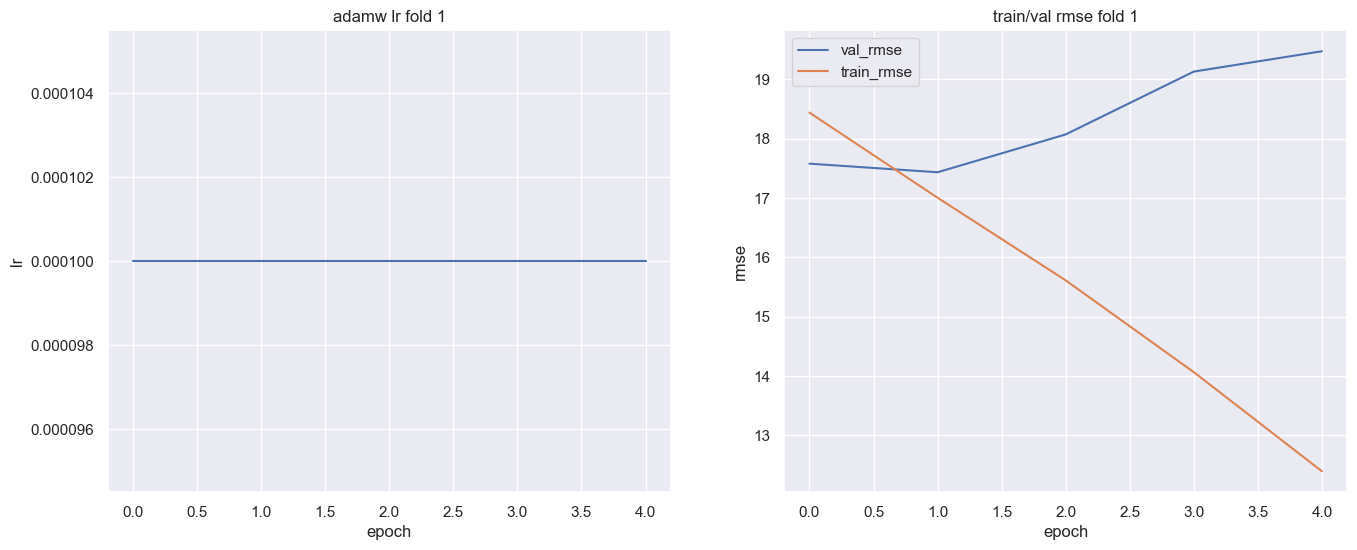

[17.735488891601562, 18.459224700927734, 18.298080444335938, 19.984474182128906]


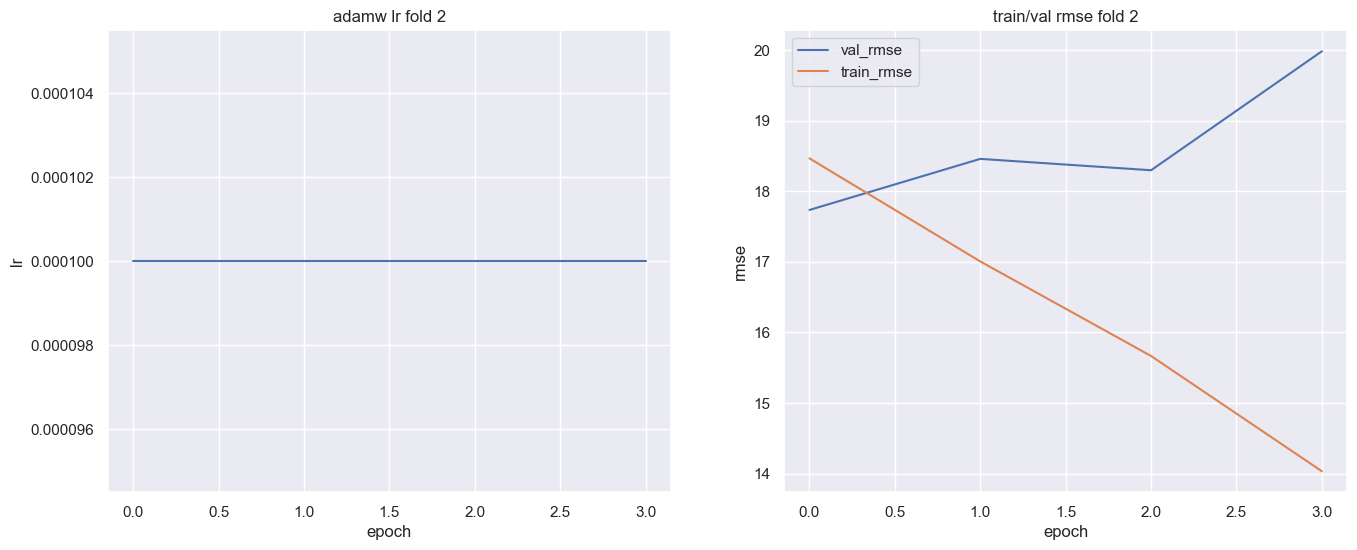

[17.66876983642578, 18.44570541381836, 18.58826446533203, 19.459697723388672]


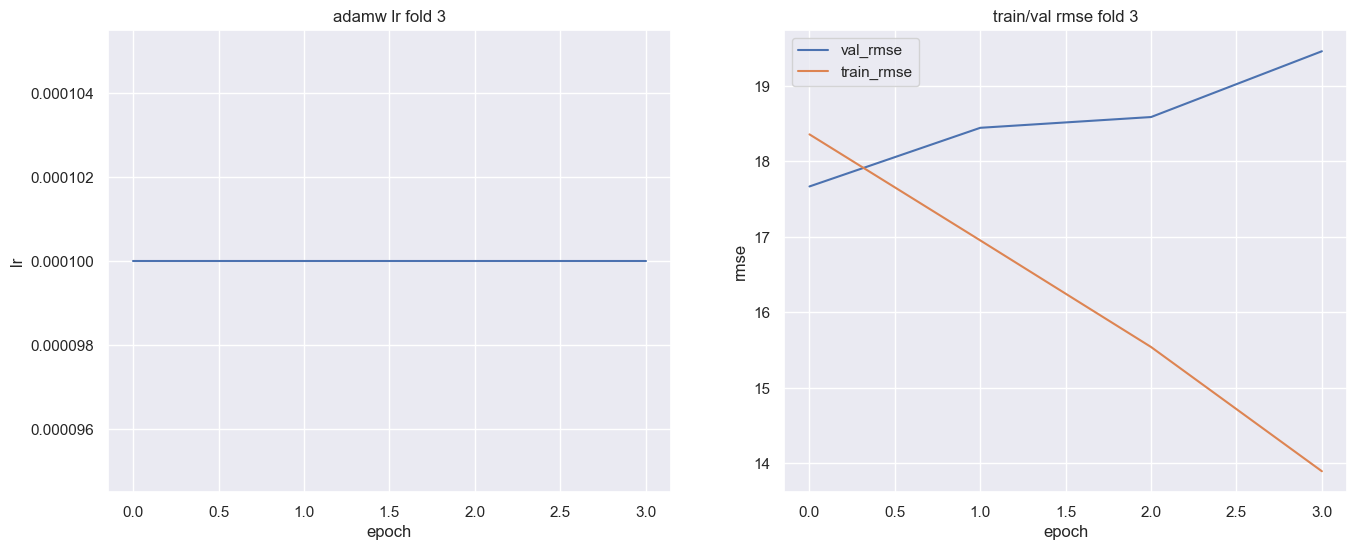

[17.995439529418945, 18.735355377197266, 19.32219123840332, 19.7477970123291]


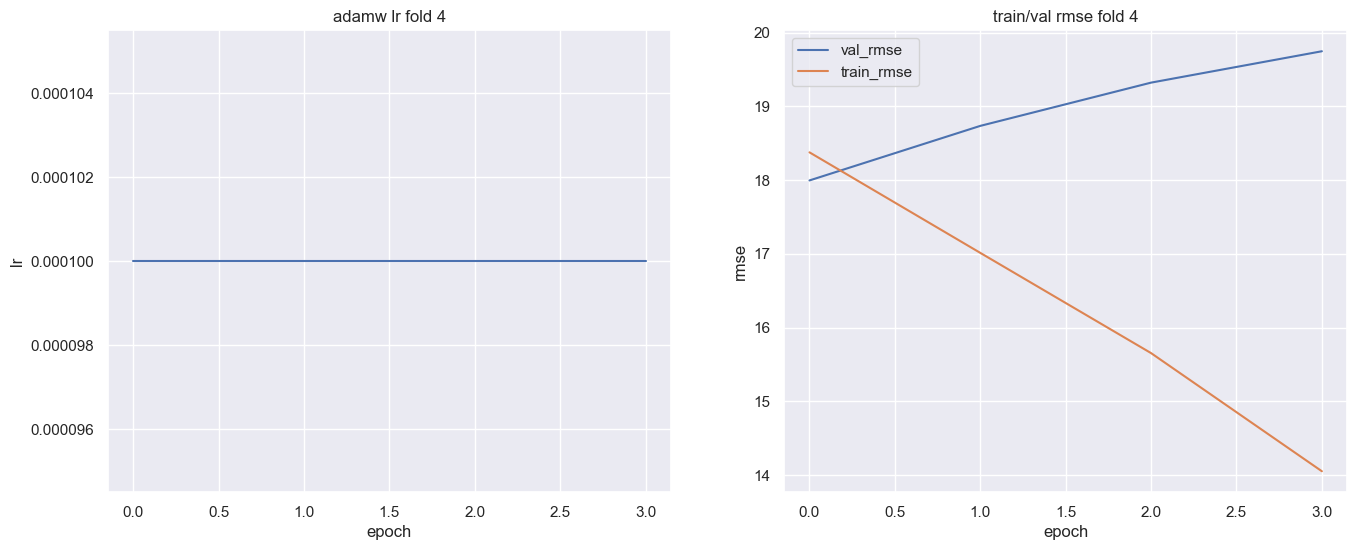

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns

for i in range(5):
    path = glob.glob(f'./output/logs/tf_efficientnet_b0_ns/lightning_logs/version_{i}/events*')[0]
    event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]

    sns.set()

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(scalars['lr-AdamW'])), scalars['lr-AdamW'])
    plt.xlabel('epoch')
    plt.ylabel('lr')
    plt.title(f'adamw lr fold {i}')

    plt.subplot(1, 2, 2)
    # plt.plot(scalars['epoch'], scalars['train_loss'], label='train_loss')
    plt.plot(range(len(scalars['val_rmse'])), scalars['val_rmse'], label='val_rmse')
    plt.plot(range(len(scalars['train_rmse'])), scalars['train_rmse'], label='train_rmse')

    print(scalars['val_rmse'])
    plt.legend()
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.title(f'train/val rmse fold {i}')
    plt.show()

# Predictions

In [ ]:
MODEL_CHECKPOINT = 'output/model_checkpoints/best_loss-v2.ckpt'

model = PawpularityModel()
model.to("cuda")
checkpoint = torch.load(MODEL_CHECKPOINT)
model.load_state_dict(checkpoint['state_dict'])

df_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
df_test = pd.concat([df_test] * 100)
df_test = df_test[:100]
test_dataloader = PetFinderDataModule(df_test=df_test, test_images_dir=TEST_IMAGES_DIR, test_augmentations=valid_aug, batch_size=8).test_dataloader()

final_image_ids = []
final_predictions = []
for batch, (image_ids, features, images, labels) in enumerate(test_dataloader):
    with torch.no_grad():
        predictions =  model(torch.as_tensor(images, dtype=torch.float32).cuda(), features.cuda())
        predictions = predictions.sigmoid() * 100
        predictions = predictions.cpu().data.numpy().reshape(-1)
    
    final_image_ids += list(image_ids)
    final_predictions += list(predictions)

df_submission = pd.DataFrame({ "Id": final_image_ids, "Pawpularity": final_predictions })
df_submission.to_csv(os.path.join(OUTPUT_DIR, 'submission.csv'), index=False)

In [ ]:
checkpoint['epoch']